<a href="https://colab.research.google.com/github/RishabhL7/Model_Comparison/blob/main/FYHGS_HGR_NET_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

#READING THE IMAGE AND LABEL FOR FINAL RECOGNITION

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
!unzip '/content/drive/MyDrive/Dataset.zip'

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: Complete/
  inflating: Complete/A-1.jpg        
  inflating: Complete/A-10.jpg       
  inflating: Complete/A-100.jpg      
  inflating: Complete/A-11.jpg       
  inflating: Complete/A-12.jpg       
  inflating: Complete/A-13.jpg       
  inflating: Complete/A-14.jpg       
  inflating: Complete/A-15.jpg       
  inflating: Complete/A-16.jpg       
  inflating: Complete/A-17.jpg       
  inflating: Complete/A-18.jpg       
  inflating: Complete/A-19.jpg       
  inflating: Complete/A-2.jpg        
  inflating: Complete/A-20.jpg       
  inflating: Complete/A-21.jpg       
  inflating: Complete/A-22.jpg       
  inflating: Complete/A-23.jpg       
  inflating: Complete/A-24.jpg       
  inflating: Complete/A-25.jpg       
  inflating: Complete/A-26.jpg       
  inflating: Complete/A-27.jpg       
  inflating: Complete/A-28.jpg       
  inflating: Complete/A-29.jpg       
  inflating: Complete/A-3.jpg        
  inflating: Complet

In [ ]:
path = "/content/Complete"

x_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_train = []
print('creating train data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_train.append(tails[0])
    n+=1

creating train data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


#SEGMENTATION MODEL

In [ ]:
#Import necessary libraries

import keras

import tensorflow as tf
from keras.datasets import mnist

from keras.models import Model,Input

from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

In [ ]:
# LATEST MODEL - LINKNET only

def ASPP(inputs):

    conv_filters = 64
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def sa_block(inputs):
    """
    Spatial Attention Module utilizing the inter-spatial relationship of features.
    """
    kernel_size = 3

    # avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    # max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)
    avg_pool = K.mean(inputs, axis=-1, keepdims=True)
    max_pool = K.max(inputs, axis=-1, keepdims=True)

    x = Concatenate()([avg_pool, max_pool])

    x = Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)

    outputs = Multiply()([inputs, x])
    return outputs

def build_LinkNet_mobilenetv2():    
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  #s1 = sa_block(s1)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  #s2 = sa_block(s2)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  #s3 = sa_block(s3)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)
  #s4 = sa_block(s4)
  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Dropout(0.15)(x)
  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug"
os.mkdir(path)

In [ ]:
#Model Checkpoint
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug/cp.ckpt"
model_checkpoint_recog_augmentation = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog_augmentation,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

#RECOGNITION MODEL

In [ ]:
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, Conv2D, Input,merge,AveragePooling2D,concatenate
from keras.models import Model

In [ ]:
# Recognition Model

class RecModel(object):
        def __init__(self, input_size,num_class):
            self.input_size=input_size
            self.num_class=num_class

            self._build_model()

        def _build_model(self):
                Smodel=build_LinkNet_mobilenetv2()
                checkpoint_path_segmentUNET = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/mobv2link_aspp_500/cp.ckpt"
                Smodel.load_weights(checkpoint_path_segmentUNET)
                l=len(Smodel.layers)
                for layer in Smodel.layers[:l]:
                    layer.trainable = False

                inp = Input(shape=self.input_size)
                inp_stream1=Smodel.input
                inp_stram2 = Smodel.output

                ###Stream1------------------

                x = Conv2D(16, 3, activation = 'relu', padding = 'same' ,dilation_rate=1,name='CV1')(inp_stream1)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV2')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV4')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV41')(x)
                xf1 = MaxPooling2D(pool_size=(3, 3))(x)
              
                ###Stream2--------------------

                x1 = Conv2D(16, 3, activation = 'relu', padding = 'same',dilation_rate=1,name='CV11')(inp_stram2)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV421')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2 ,name='CV31')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV412')(x1)
                xf2 = MaxPooling2D(pool_size=(3, 3))(x1)

                ####--------
                f = keras.layers.concatenate([xf1,xf2], axis = 3) 
                f = MaxPooling2D(pool_size=(3, 3))(f)


                f = Flatten()(f)

                f = Dropout(0.2)(f)

                prediction = Dense(self.num_class, activation="softmax")(f)
                model_final = Model(Smodel.input, prediction)
                                                    


                self.model_F=model_final

In [ ]:
input_size = (320,320,3)
num_class = 10
RecM=RecModel((320,320,3), 10)
model=RecM.model_F
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                             

In [ ]:
#Our CNN model
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

# **WITHOUT DATA AUGMENTATION**

Check if the model gives any value of accuracy without fitting it first


In [ ]:
_adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    decay=0.0
)
model.compile(loss='binary_crossentropy',optimizer = _adam,metrics=['accuracy'])


In [ ]:
y_debug_pred = model.predict(x_train)

In [ ]:
np.argmax(y_debug_pred[0])

9

In [ ]:
model.evaluate(x_train, y_train)

32/32 [==============================] - 8s 137ms/step - loss: 3.4118 - accuracy: 0.1000


[3.411794900894165, 0.10000000149011612]

Model predict is giving a value
NOW WE FIT THE DATA

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData"
os.mkdir(path)

In [ ]:
#Model Checkpoint
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt"
model_checkpoint_recog_augmentation = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog_augmentation,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(x_train, y_train, batch_size=2, epochs=50,validation_split=0.1, callbacks=[model_checkpoint_recog_augmentation])

Epoch 1/50
448/450 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.6116
Epoch 1: val_accuracy improved from -inf to 0.98000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt
450/450 [==============================] - 24s 29ms/step - loss: 0.2497 - accuracy: 0.6122 - val_loss: 0.0370 - val_accuracy: 0.9800
Epoch 2/50
449/450 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9800
Epoch 2: val_accuracy improved from 0.98000 to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt
450/450 [==============================] - 12s 27ms/step - loss: 0.0323 - accuracy: 0.9800 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 3/50
449/450 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9900
Epoch 3: val_accuracy did not improve from 1.00000
450/450 [==============================] - 11s 25ms/step - loss: 0.0161 - accuracy: 0.9900 - val_loss:

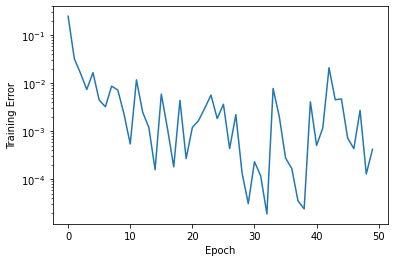

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_UNAUGMENTED.png')

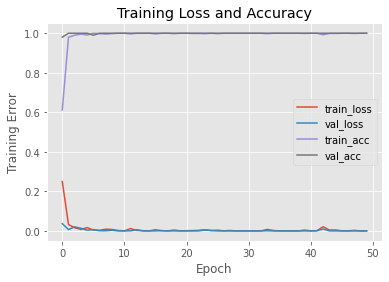

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_RECOGNITION_Unaugmented.png')

In [ ]:
model.load_weights(checkpoint_path_recog)

TEST DATA

In [ ]:
path = "/content/OUHANDS_Siddhant/testing/colour"

x_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_test = []
print('creating test data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_test.append(tails[0])
    n+=1

creating test data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s]


In [ ]:
y_test

In [ ]:
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(1000, 320, 320, 3)
(1000,)


#SAVE THE MODEL

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/Data.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/Data_weights.h5')

#Test Data

In [ ]:
!mkdir Extracting_folder

In [ ]:
import shutil 
shutil.unpack_archive("/content/drive/MyDrive/Complete.zip", "/content/Extracting_folder")

In [ ]:
!unzip '/content/drive/MyDrive/Complete.zip'

In [ ]:
path = '/content/Extracting_folder/Complete'

x_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_test = []
print('creating test data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_test.append(tails[0])
    n+=1

creating test data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [01:58<00:00,  8.46it/s]


In [ ]:
y_test

In [ ]:
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

In [ ]:
y_test

In [ ]:
print(x_test.shape)
print(y_test.shape)

(1000, 320, 320, 3)
(1000,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
 #    ######evaluate#####
checkpoint_path_recog = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/Data_weights.h5"
model.load_weights(checkpoint_path_recog)




In [ ]:
y_pred=model.predict(x_test)

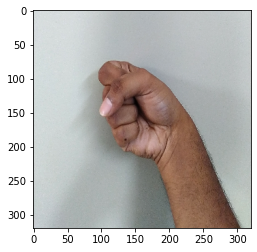

In [ ]:
plt.imshow(array_to_img(x_test[5]))

In [ ]:
y_classes = [np.argmax(i) for i in y_pred]

In [ ]:
y_classes[:5]

[8, 6, 4, 3, 3]

In [ ]:
y_test[:5]

array([8, 6, 0, 1, 1])

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.62      0.75       100
           1       0.55      0.55      0.55       100
           2       0.91      0.43      0.59       100
           3       0.61      0.78      0.69       100
           4       0.88      0.86      0.87       100
           5       0.84      0.79      0.81       100
           6       0.69      0.77      0.73       100
           7       0.71      0.97      0.82       100
           8       0.82      0.96      0.88       100
           9       0.86      0.89      0.87       100

    accuracy                           0.76      1000
   macro avg       0.78      0.76      0.76      1000
weighted avg       0.78      0.76      0.76      1000



Text(69.0, 0.5, 'Truth')

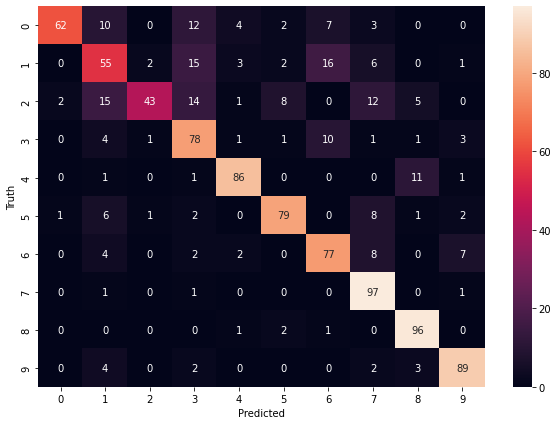

In [ ]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print("F1-Score", f1_score(y_test, y_classes, average='macro'))

F1-Score 0.7562658560186757
